In [53]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import tensorflow as tf
import seaborn as sns
import shap 

In [54]:
#load the CSV data file in pandas frame
#df = pd.read_csv(r'C:\Users\keswa\OneDrive - Universiti Teknikal Malaysia Melaka\UTEM\BITU 3973 (FYP)\Data-Biochar-Yield.csv', index_col = 'Unnamed: 0')

# Try reading the CSV file with a different encoding
file_path = r'C:\Users\keswa\OneDrive - Universiti Teknikal Malaysia Melaka\UTEM\BITU 3973 (FYP)\Data-Biochar-Yield.csv'
try:
    df = pd.read_csv(file_path, index_col='Unnamed: 0', encoding='latin1')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, index_col='Unnamed: 0', encoding='iso-8859-1')

print(df.head())

   Fixed carbon  Volatile matter       Ash      C     H      O     N  \
0     18.006795        78.708947  3.284258  48.12  6.48  43.51  1.89   
1     18.006795        78.708947  3.284258  48.12  6.48  43.51  1.89   
2     18.006795        78.708947  3.284258  48.12  6.48  43.51  1.89   
3     18.006795        78.708947  3.284258  48.12  6.48  43.51  1.89   
4     18.006795        78.708947  3.284258  48.12  6.48  43.51  1.89   

   Residence time (min)  Temperature (°C)  Heating rate (°C/min)  \
0                    30               400                     15   
1                    60               400                     10   
2                    90               400                      5   
3                    30               500                     15   
4                    60               500                     10   

   Biochar yield (%)  
0              30.80  
1              26.60  
2              26.77  
3              23.57  
4              25.32  


In [55]:
# Data pre-processing
# Input the feedstock variable
features_values = [
    'Fixed carbon',
    'Volatile matter',
    'Ash',
    'C',
    'H',
    'O',
    'N',
    'Residence time (min)',
    'Temperature (°C)',
    'Heating rate (°C/min)',
]

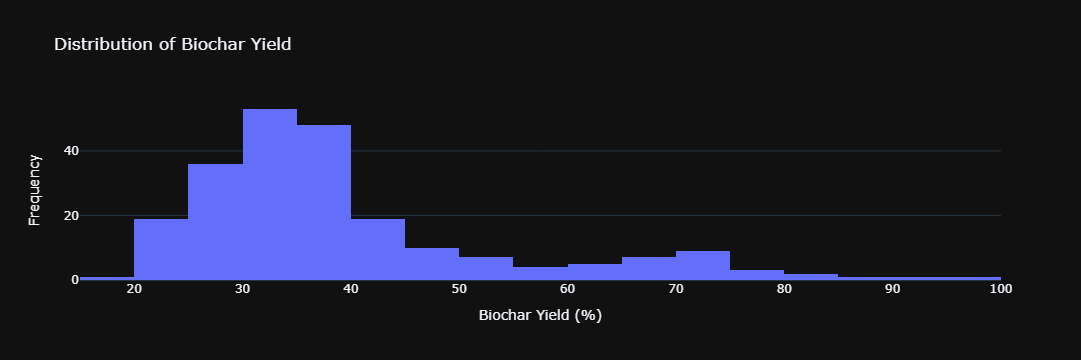

In [56]:
fig = px.histogram(
    df, 
    x='Biochar yield (%)', 
    histfunc='count', 
    template='plotly_dark', 
    title='Distribution of Biochar Yield',
    labels={'Biochar yield (%)': 'Biochar Yield (%)'},  # Renaming x-axis label
)

fig.update_layout(
    xaxis_title='Biochar Yield (%)',
    yaxis_title='Frequency'
)

fig.show()

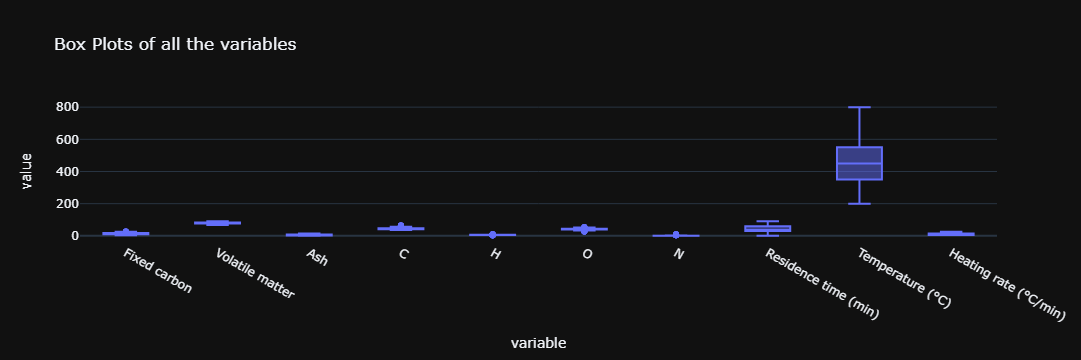

In [57]:
#Visualisation of all the variables (WWTP) 
fig = px.box(df, y=df.drop(['Biochar yield (%)'], axis=1).columns, template='plotly_dark', title='Box Plots of all the variables')
fig.show()

In [58]:
# Define features and label
X = df.drop(['Biochar yield (%)'], axis=1)
y_bio = df['Biochar yield (%)']


In [59]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame for better understanding and consistency
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the first few rows of the normalized data
print(X_scaled_df.head())


   Fixed carbon  Volatile matter       Ash        C         H        O  \
0       0.77843        -0.228527 -0.773912  0.72454  0.547071  0.17986   
1       0.77843        -0.228527 -0.773912  0.72454  0.547071  0.17986   
2       0.77843        -0.228527 -0.773912  0.72454  0.547071  0.17986   
3       0.77843        -0.228527 -0.773912  0.72454  0.547071  0.17986   
4       0.77843        -0.228527 -0.773912  0.72454  0.547071  0.17986   

          N  Residence time (min)  Temperature (°C)  Heating rate (°C/min)  
0  0.358599             -0.431791         -0.487082               0.639514  
1  0.358599              1.170587         -0.487082              -0.241767  
2  0.358599              2.772966         -0.487082              -1.123048  
3  0.358599             -0.431791          0.315839               0.639514  
4  0.358599              1.170587          0.315839              -0.241767  


In [60]:
# Split the dataset into training and testing subsets for Biochar Yield
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_bio, test_size=0.2, random_state=32)


In [61]:
# Define thresholds for classifying biochar yield
low_threshold = 30  # Example threshold for low yield
high_threshold = 70  # Example threshold for high yield



In [62]:
# Convert biochar yield to categorical labels
y_train_class = pd.cut(y_train, bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])
y_test_class = pd.cut(y_test, bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['Low', 'Medium', 'High'])

# Convert labels to one-hot encoding
y_train_encoded = pd.get_dummies(y_train_class)
y_test_encoded = pd.get_dummies(y_test_class)



In [63]:
# Create TensorFlow data generators
batch_size = 12


train_data_gen = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded)).shuffle(buffer_size=len(X_train)).batch(batch_size)
validation_data_gen = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded)).batch(batch_size)


In [64]:
# Neural network model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use Input layer instead
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with softmax activation for multiclass classification
])


In [65]:
# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using data generators
history = model.fit(
   train_data_gen,
   epochs=70,
   validation_data=validation_data_gen,
   verbose=1
)


Epoch 1/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2610 - loss: 1.1772 - val_accuracy: 0.6957 - val_loss: 0.9131
Epoch 2/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 0.8314 - val_accuracy: 0.6739 - val_loss: 0.7908
Epoch 3/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.6389 - val_accuracy: 0.7174 - val_loss: 0.7436
Epoch 4/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7864 - loss: 0.5516 - val_accuracy: 0.6739 - val_loss: 0.7081
Epoch 5/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7795 - loss: 0.5532 - val_accuracy: 0.6739 - val_loss: 0.6745
Epoch 6/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8412 - loss: 0.4477 - val_accuracy: 0.6739 - val_loss: 0.6441
Epoch 7/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8670 - loss: 0.3921 - val_accuracy: 0.6957 - val_loss: 0.6117
Epoch 8/70
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.3546 - val_accuracy: 0.6957 - val_loss

In [66]:
# Evaluate the model using accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("\n\033[1;33;40mFinal Training Accuracy: ", train_accuracy)
print("\n\033[1;31;47mFinal Validation Accuracy: " , val_accuracy)




Final Training Accuracy:  0.9888888597488403

Final Validation Accuracy:  0.760869562625885


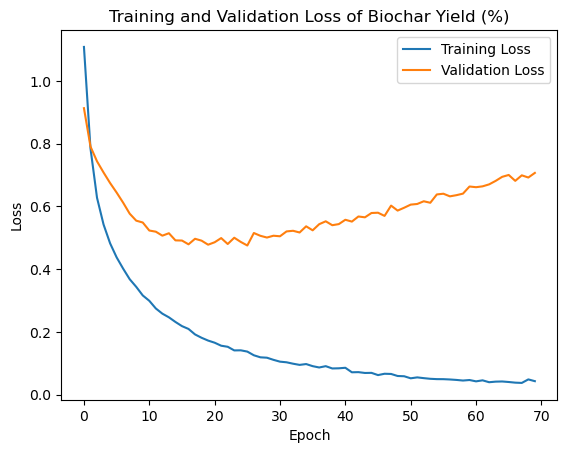

In [67]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Biochar Yield (%)')
plt.show()

In [68]:
# Initialize lists to store metrics (if not already initialized)
if 'accuracy_list' not in globals():
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

# Predict classes on the test set
y_pred_proba = model.predict(X_test)
y_pred_class = np.argmax(y_pred_proba, axis=1)
y_test_class_encoded = np.argmax(y_test_encoded.values, axis=1)

# Calculate classification metrics
accuracy = accuracy_score(y_test_class_encoded, y_pred_class)
precision = precision_score(y_test_class_encoded, y_pred_class, average='weighted')
recall = recall_score(y_test_class_encoded, y_pred_class, average='weighted')
f1 = f1_score(y_test_class_encoded, y_pred_class, average='weighted')

# Print the metrics
print(f"\n\033[1;31;47mAccuracy: {accuracy}")
print(f"\033[1;31;47mPrecision: {precision}")
print(f"\033[1;31;47mRecall: {recall}")
print(f"\033[1;31;47mF1 Score: {f1}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Accuracy: 0.7608695652173914
Precision: 0.7578307620383355
Recall: 0.7608695652173914
F1 Score: 0.7581712656552285


In [69]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_encoded, y_pred_proba) * 100
print(f"\033[1;31;47mMean Squared Error: {mse}")


Mean Squared Error: 12.915822863578796



SHAP Summary Plot for Class: Low


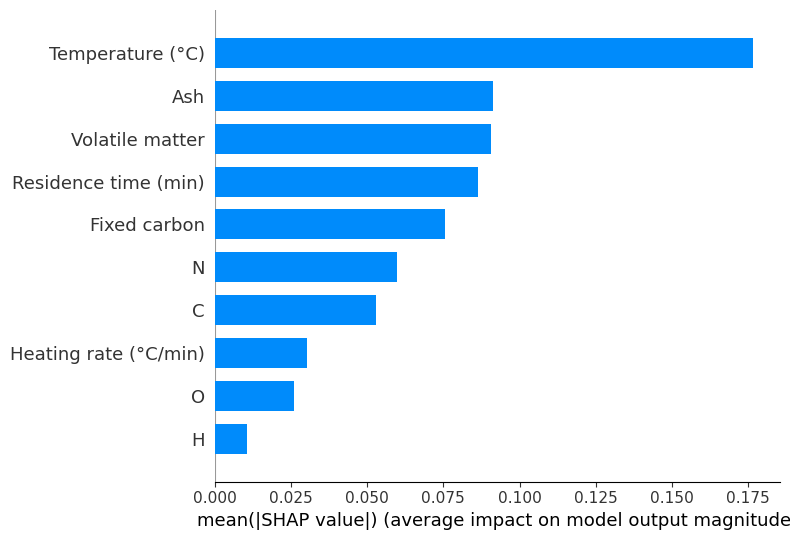


SHAP Summary Plot for Class: Medium


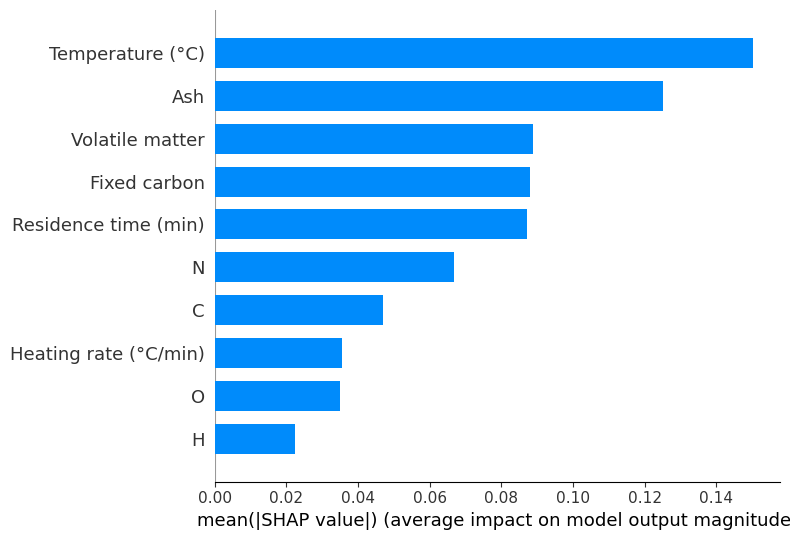


SHAP Summary Plot for Class: High


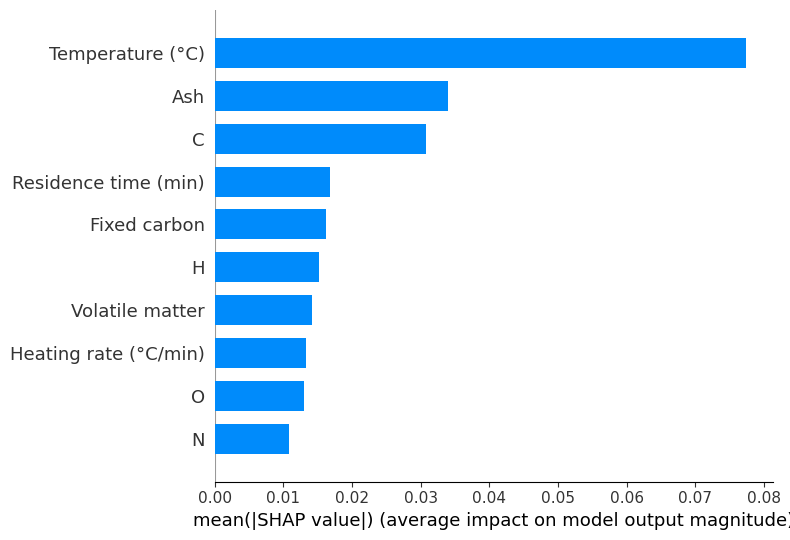


SHAP Beeswarm Plot for Class: Low


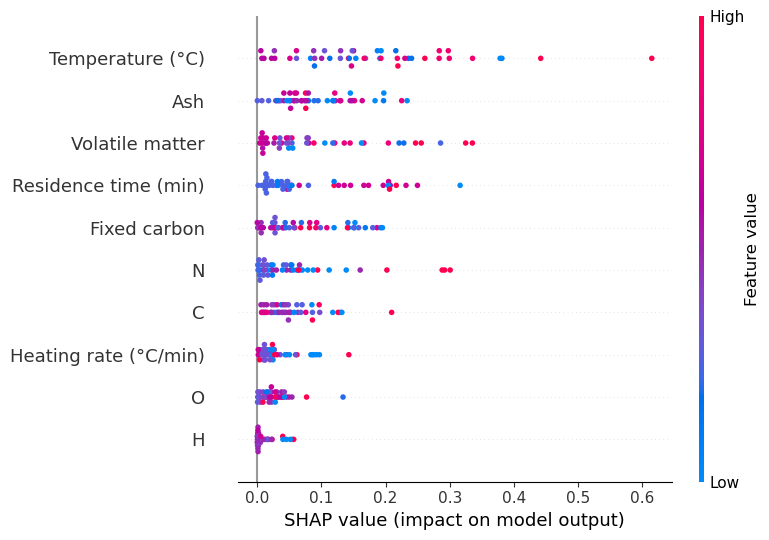


SHAP Beeswarm Plot for Class: Medium


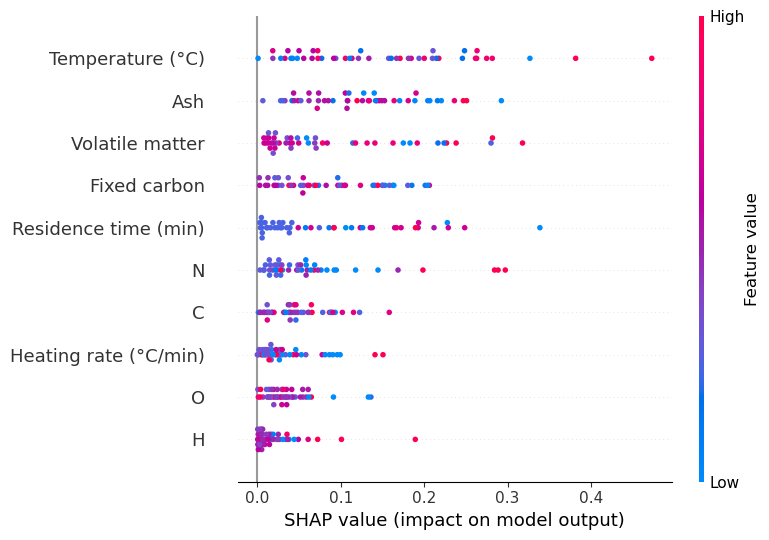


SHAP Beeswarm Plot for Class: High


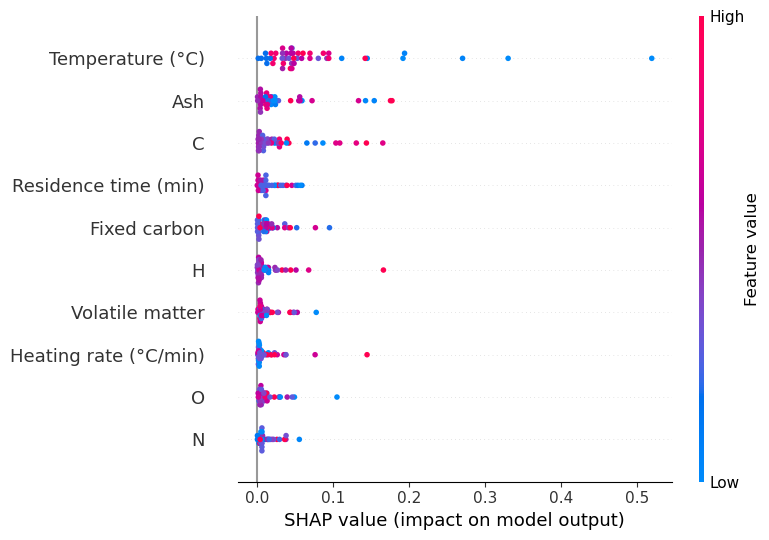

In [70]:
# SHAP analysis using the unified SHAP Explainer
# Using a sample of the training set for SHAP values calculation due to high computational cost
sample_size = 100  # You can adjust this size
X_train_sample = X_train[:sample_size]
y_train_encoded_sample = y_train_encoded[:sample_size]

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train_sample)
shap_values = explainer(X_test)

# Extract SHAP values for each class
shap_values_class_0 = shap_values[:, :, 0].values  # Low
shap_values_class_1 = shap_values[:, :, 1].values  # Medium
shap_values_class_2 = shap_values[:, :, 2].values  # High

# Convert SHAP values to absolute values for each class
shap_values_abs_0 = np.abs(shap_values_class_0)
shap_values_abs_1 = np.abs(shap_values_class_1)
shap_values_abs_2 = np.abs(shap_values_class_2)

# Plot SHAP summary plot for each class
for i, (shap_values_abs, class_name) in enumerate(zip([shap_values_abs_0, shap_values_abs_1, shap_values_abs_2], ['Low', 'Medium', 'High'])):
    print(f"\nSHAP Summary Plot for Class: {class_name}")
    shap.summary_plot(shap_values_abs, X_test, feature_names=X.columns, plot_type='bar')

# Alternatively, if you want to use the beeswarm plot with absolute values
for i, (shap_values_abs, class_name) in enumerate(zip([shap_values_abs_0, shap_values_abs_1, shap_values_abs_2], ['Low', 'Medium', 'High'])):
    print(f"\nSHAP Beeswarm Plot for Class: {class_name}")
    shap.summary_plot(shap_values_abs, X_test, feature_names=X.columns, plot_type='dot')

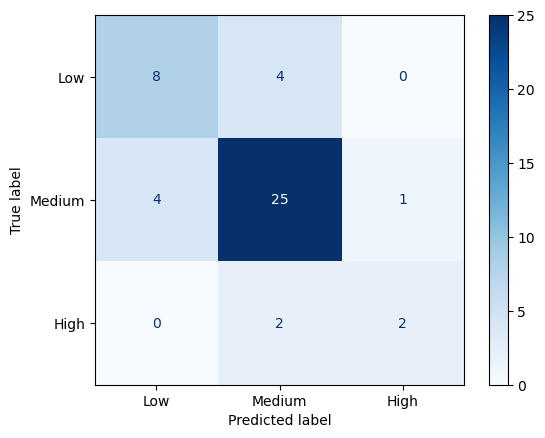

In [71]:
# Confusion matrix
cm = confusion_matrix(y_test_class_encoded, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [72]:
# Store the results for visualization
accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)
f1_list.append(f1)

# Create a DataFrame to display the metrics at each step
metrics_df = pd.DataFrame({
    'Run': range(1, len(accuracy_list) + 1),
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the DataFrame in a styled table format for better visualization
styled_df = metrics_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])
display(styled_df)

,Run,Accuracy,Precision,Recall,F1 Score
0,1,0.695652,0.649666,0.695652,0.671865
1,2,0.739130,0.765217,0.739130,0.730435
2,3,0.760870,0.757831,0.760870,0.758171


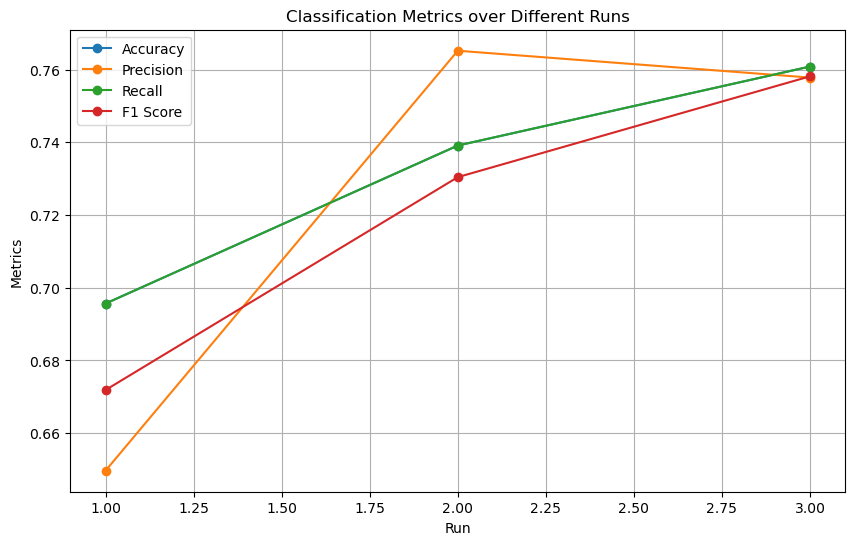

In [73]:
# Plot the metrics over different runs
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Run'], metrics_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(metrics_df['Run'], metrics_df['Precision'], marker='o', label='Precision')
plt.plot(metrics_df['Run'], metrics_df['Recall'], marker='o', label='Recall')
plt.plot(metrics_df['Run'], metrics_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('Run')
plt.ylabel('Metrics')
plt.title('Classification Metrics over Different Runs')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
#Finding importance Features usng permutation Importance

In [75]:
# Permutation importance function for classification
def permutation_importance(model, X, y, metric_func):
    baseline_performance = metric_func(y, np.argmax(model.predict(X), axis=1))
    importances = []
    
    for col in range(X.shape[1]):
        X_permuted = X.copy().values  # Ensure we are working with numpy array for shuffling
        np.random.shuffle(X_permuted[:, col])
        permuted_performance = metric_func(y, np.argmax(model.predict(X_permuted), axis=1))
        importances.append(baseline_performance - permuted_performance)
    
    return np.array(importances)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


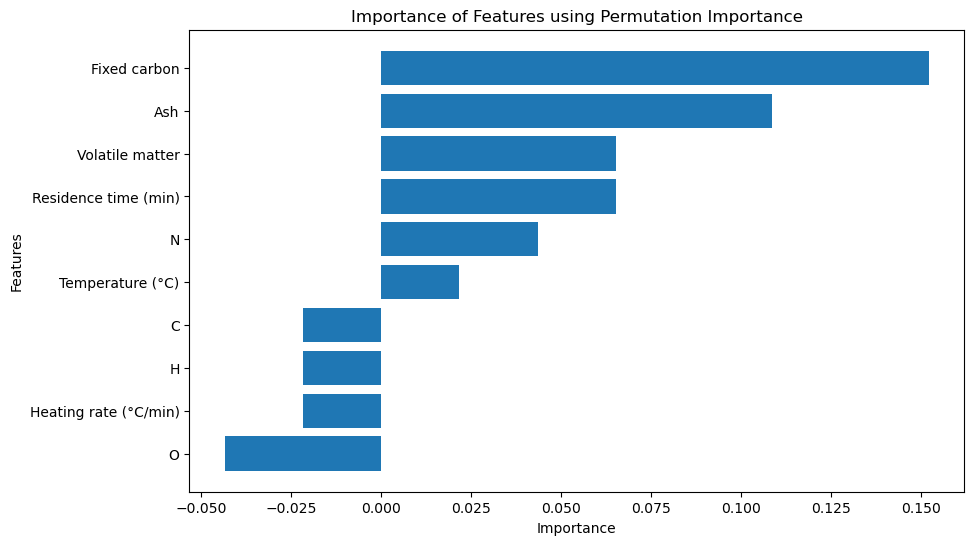

In [76]:
# Calculate permutation importances using accuracy
importances = permutation_importance(model, X_test, y_test_class_encoded, accuracy_score)

# Create a DataFrame for easier sorting
feature_importance_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': importances
})

# Sort the DataFrame by the importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar graph to visualize the importance of features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Importance of Features using Permutation Importance')
plt.gca().invert_yaxis()  # Reverse the order to have the most important on top
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


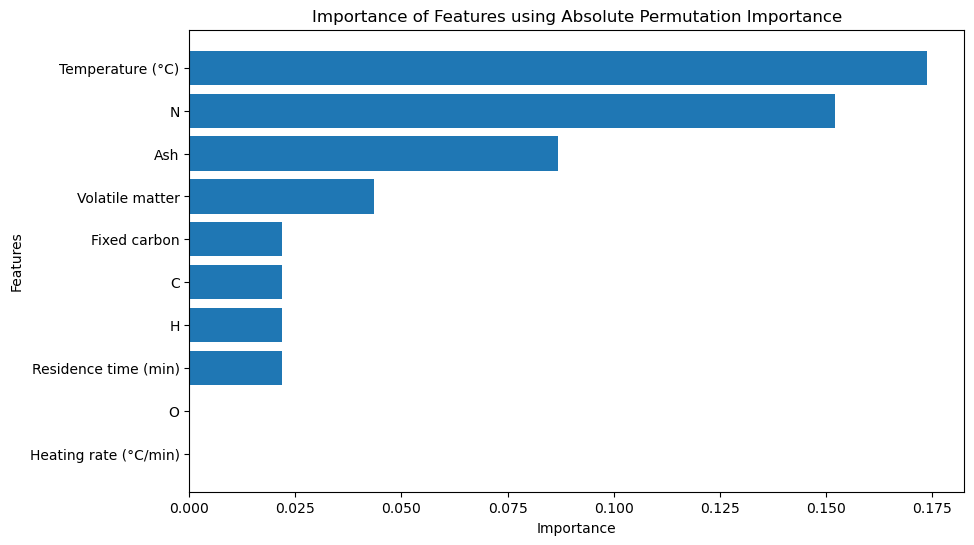

In [77]:
# Calculate permutation importances using accuracy
importances = permutation_importance(model, X_test, y_test_class_encoded, accuracy_score)

# Create a DataFrame for easier sorting
feature_importance_df = pd.DataFrame({
    'Feature': X_scaled_df.columns,
    'Importance': np.abs(importances)  # Use absolute values for importance
})

# Sort the DataFrame by the importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar graph to visualize the importance of features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Importance of Features using Absolute Permutation Importance')
plt.gca().invert_yaxis()  # Reverse the order to have the most important on top
plt.show()

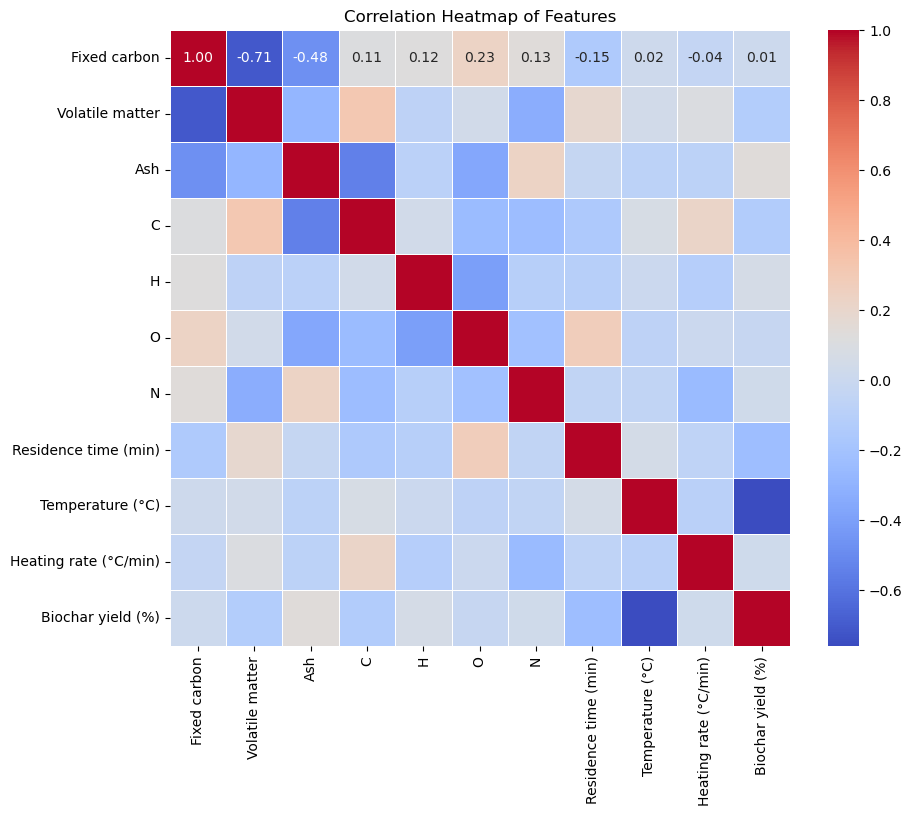

In [78]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()